In [83]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import time
import shutil
import os
import random
import cv2
import math
import json

from keras.preprocessing.image import *

from IPython.display import display # Allows the use of display() for DataFrames
# Visualizations will be shown in the notebook.
%matplotlib inline

Using TensorFlow backend.


In [84]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

columns = ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed']
data = pd.read_csv('udacity/data/data/driving_log.csv', names=columns)
print("Dataset Columns:", columns, "\n")
print("Shape of the dataset:", data.shape, "\n")
print(data.describe(), "\n")

print("Data loaded...")

Dataset Columns: ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed'] 

Shape of the dataset: (8037, 7) 

                                        center  \
count                                     8037   
unique                                    8037   
top     IMG/center_2016_12_01_13_33_53_154.jpg   
freq                                         1   

                                         left  \
count                                    8037   
unique                                   8037   
top      IMG/left_2016_12_01_13_37_16_974.jpg   
freq                                        1   

                                         right steering_angle    throttle  \
count                                     8037           8037        8037   
unique                                    8037            125          96   
top      IMG/right_2016_12_01_13_40_12_792.jpg              0   0.9855326   
freq                                         1           4361     

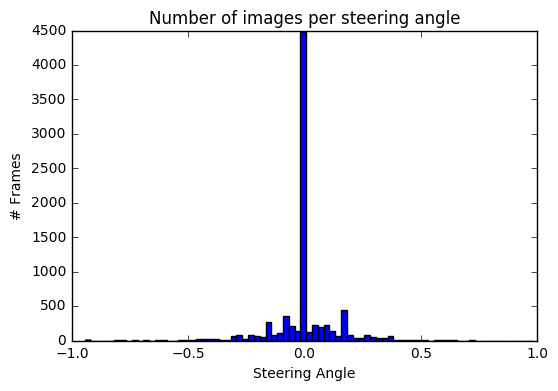

In [85]:
binwidth = 0.025
steers = data['steering_angle'][1:].astype('float')
bins = np.arange(min(steers), max(steers), binwidth)
plt.hist(steers, bins)
plt.title('Number of images per steering angle')
plt.xlabel('Steering Angle')
plt.ylabel('# Frames')
plt.show()


In [86]:
# Get randomized datasets for training and validation
steers = steers.reindex(np.random.permutation(steers.index))
num_train = int((len(steers) / 10.0) * 9.0)
assert(num_train > 0)
X_train = steers.iloc[:num_train]
X_test = steers.iloc[num_train:]
print(X_train.shape, X_test.shape)

(7232,) (804,)


In [96]:
#flip an image
def flip_image(image, steer_angle):
    flipped = cv2.flip(image, 1)
    angle_f = -1.0 * steer_angle
    return flipped, angle_f


In [97]:
# shift height/width of the image by a small fraction
def height_width_shift(img, steering_angle):
    rows, cols, channels = img.shape
    
    # Translation
    tx = WIDTH_SHIFT_RANGE * np.random.uniform() - WIDTH_SHIFT_RANGE / 2
    ty = HEIGHT_SHIFT_RANGE * np.random.uniform() - HEIGHT_SHIFT_RANGE / 2
    steering_angle = steering_angle + tx / WIDTH_SHIFT_RANGE * 2 * .2
    
    transform_matrix = np.float32([[1, 0, tx],
                                   [0, 1, ty]])
    
    translated_image = cv2.warpAffine(img, transform_matrix, (cols, rows))
    return translated_image, steering_angle

In [98]:
def brightness_shift(img, bright_value=None):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    if bright_value:
        img[:,:,2] += bright_value
    else:
        random_bright = .25 + np.random.uniform()
        img[:,:,2] = img[:,:,2] * random_bright
    
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

In [99]:
# crop the top 1/5 of the image to remove the horizon and the bottom 25 pixels to remove the car’s hood
def crop_resize_image(img):
    shape = img.shape
    img = img[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
    img = cv2.resize(img, (PROCESSED_IMG_COLS, PROCESSED_IMG_ROWS), interpolation=cv2.INTER_AREA)    
    return img

In [106]:
#this is the wrapper for all the transformations above. 
def apply_random_transformation(img, steering_angle):
    
    transformed_image, steering_angle = height_width_shift(img, steering_angle)
    transformed_image = brightness_shift(transformed_image)
    # transformed_image = channel_shift(transformed_image) # increasing train time. not much benefit. commented
    
    if np.random.random() < 0.5:
        transformed_image, steering_angle = horizontal_flip(transformed_image, steering_angle)
            
    transformed_image = crop_resize_image(transformed_image)
    
    return transformed_image, steering_angle

In [108]:
# image augmentation variables
CAMERA_OFFSET = 0.25
CHANNEL_SHIFT_RANGE = 0.2
WIDTH_SHIFT_RANGE = 100
HEIGHT_SHIFT_RANGE = 40

# processed image variables
PROCESSED_IMG_COLS = 64
PROCESSED_IMG_ROWS = 64
PROCESSED_IMG_CHANNELS = 3

# model training variables
NB_EPOCH = 8
BATCH_SIZE = 256

In [109]:

# shift range for each channels
def channel_shift(img, channel_shift_range=CHANNEL_SHIFT_RANGE):
    img_channel_index = 2 # tf indexing
    channel_shifted_image = random_channel_shift(img, channel_shift_range, img_channel_index)
    return channel_shifted_image

In [110]:
def read_image(fn):
    img = load_img(fn)
    img = img_to_array(img) 
    return img

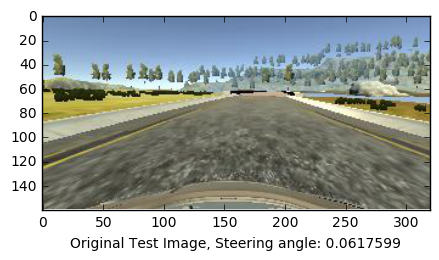

In [111]:

test_fn = "udacity/data/data/IMG/center_2016_12_01_13_32_43_457.jpg"
steering_angle = 0.0617599

test_image = read_image(test_fn)

plt.subplots(figsize=(5, 18))

# original image
plt.subplot(611)
plt.xlabel("Original Test Image, Steering angle: " + str(steering_angle))
plt.imshow(array_to_img(test_image))

(160, 320, 3) (160, 320, 3)


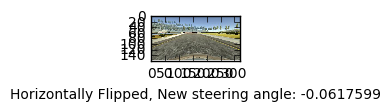

In [117]:

# horizontal flip augmentation
flipped_image, new_steering_angle = flip_image(test_image, steering_angle)
plt.subplot(612)
plt.xlabel("Horizontally Flipped, New steering angle: " + str(new_steering_angle))
plt.imshow(array_to_img(flipped_image))
print(flipped_image.shape, test_image.shape)

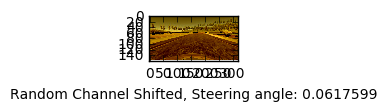

In [113]:

# channel shift augmentation
channel_shifted_image = channel_shift(test_image, 255)
plt.subplot(613)
plt.xlabel("Random Channel Shifted, Steering angle: " + str(steering_angle))
plt.imshow(array_to_img(channel_shifted_image))


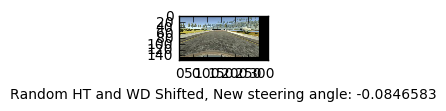

In [114]:

# width shift augmentation
width_shifted_image, new_steering_angle = height_width_shift(test_image, steering_angle)
new_steering_angle = "{:.7f}".format(new_steering_angle)
plt.subplot(614)
plt.xlabel("Random HT and WD Shifted, New steering angle: " + str(new_steering_angle))
plt.imshow(array_to_img(width_shifted_image))


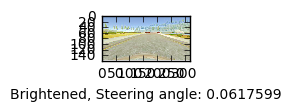

In [115]:

# brightened image
brightened_image = brightness_shift(test_image, 255)
plt.subplot(615)
plt.xlabel("Brightened, Steering angle: " + str(steering_angle))
plt.imshow(array_to_img(brightened_image))

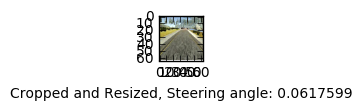

In [116]:
# crop augmentation
cropped_image = crop_resize_image(test_image)
plt.subplot(616)
plt.xlabel("Cropped and Resized, Steering angle: " + str(steering_angle))
_ = plt.imshow(array_to_img(cropped_image))